In [1]:
import cv2
import pickle
import os.path
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,MaxPooling2D,Dense,Dropout
from keras import backend as k
from keras.layers.normalization import BatchNormalization
from keras.models import model_from_json
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
!git clone https://github.com/magus96/BCDCNN_2.git
  

Cloning into 'BCDCNN_2'...
remote: Enumerating objects: 1519, done.
remote: Counting objects: 100% (1519/1519), done.
remote: Compressing objects: 100% (1519/1519), done.
remote: Total 1519 (delta 3), reused 1509 (delta 0), pack-reused 0
Receiving objects: 100% (1519/1519), 173.52 MiB | 39.55 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
cd '/content/BCDCNN_2/'


/content/BCDCNN_2


In [0]:
from helpers import resize_to_fit
path='/content/BCDCNN_2/Data'
data=[]
labels=[]
for image_file in paths.list_images(path):
    image=cv2.imread(image_file)
    image=resize_to_fit(image,128,128)
    label=image_file.split(os.path.sep)[-2]
    data.append(image)
    labels.append(label)
    
    

We initialize data and label as empty vectors. We iterate through the folder(s) containing our test images. The names of the subfolders are the labels themselves(0-Benign 1-Malignant). We use openCV for our image manipulation. From exhaustive testing, we found that 128 * 128 pixels was the best image size for our purpose. We append the images to the data vector with corresponding labels stored in the labels vector.

In [5]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(np.expand_dims(labels, axis=1))

print(data.shape)
print(labels.shape)

(1182, 128, 128, 3)
(1182, 1)


We convert our vectors into numpy arrays as they are easy to manipulate and are a lot faster to operate on. Since we have 1482 images of 128 * 128 pixels and 3 channels(RGB channel), we get an array of shape(1482,128,128,3). We also normalize the pixel by dividing them by 255. We convert the labels vector to a similar numpy array with 1 column and 1482 labels.

In [6]:
lb=LabelBinarizer().fit(labels)
labels=lb.transform(labels)
print(labels.shape)

(1182, 1)


We one hot encode the labels although it isnt entirely necessary to do this for binary classification.

In [0]:
X_train,X_test,y_train,y_test=train_test_split(data,labels,test_size=0.2,random_state=109)

We split the dataset into train and testing data. The test size is 20% of the total dataset.

In [8]:
print(X_train.shape)
print(X_test.shape)

(945, 128, 128, 3)
(237, 128, 128, 3)


In [9]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128,128,3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4

model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D((2, 2), strides=(2, 2)))
  
model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
print(model.summary())
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 256)       0         
__________

We initialize our Convolutional Neural Network. An input size of (128,128,3) is required according to the image size. Precision being the need of the hour, we use 5 convolutional layers for maximum feature extraction. The final layer is a fully connected layer with 2 outputs and a sigmoid activation function. This outputs the probabilities for each class for a given image.

In [0]:
batch_size=64
epochss=20


We choose a batch size of 64 due to memory considerations. We train our network for 20 epochs.

In [11]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=batch_size,epochs=epochss)


Train on 945 samples, validate on 237 samples
Epoch 1/20
945/945 [==============================] - 14s 15ms/step - loss: 0.7673 - acc: 0.5397 - val_loss: 0.6858 - val_acc: 0.4768
Epoch 2/20
945/945 [==============================] - 4s 5ms/step - loss: 0.6290 - acc: 0.6794 - val_loss: 0.5492 - val_acc: 0.8270
Epoch 3/20
945/945 [==============================] - 4s 5ms/step - loss: 0.4694 - acc: 0.8116 - val_loss: 0.3652 - val_acc: 0.8608
Epoch 4/20
945/945 [==============================] - 4s 5ms/step - loss: 0.3565 - acc: 0.8677 - val_loss: 0.3051 - val_acc: 0.8903
Epoch 5/20
945/945 [==============================] - 4s 5ms/step - loss: 0.2721 - acc: 0.8995 - val_loss: 0.3026 - val_acc: 0.8776
Epoch 6/20
945/945 [==============================] - 4s 5ms/step - loss: 0.2252 - acc: 0.9058 - val_loss: 0.2043 - val_acc: 0.9072
Epoch 7/20
945/945 [==============================] - 4s 5ms/step - loss: 0.1888 - acc: 0.9196 - val_loss: 0.1667 - val_acc: 0.9283
Epoch 8/20
945/945 [========

We call the fit() function to train our network.

In [12]:
model_json=model.to_json()
with open("model.json","w") as json_file:
     json_file.write(model_json)
model.save_weights("model.h5")
print("saved model to disk")
json_file = open("model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
  


saved model to disk
Loaded model from disk


In [0]:
from helpers import resize_to_fit
path='/content/BCDCNN_2/Validation'
data1=[]
labels1=[]
for image_file in paths.list_images(path):
    image=cv2.imread(image_file)
    image=resize_to_fit(image,128,128)
    label=image_file.split(os.path.sep)[-2]
    data1.append(image)
    labels1.append(label)
    
    

We use a similar process as before but this time we use it on the testdata set.

In [14]:
data1 = np.array(data1, dtype="float") / 255.0
labels1 = np.array(np.expand_dims(labels1, axis=1))

print(data1.shape)
print(labels1.shape)

(398, 128, 128, 3)
(398, 1)


In [15]:
lb=LabelBinarizer().fit(labels1)
labels1=lb.transform(labels1)
print(labels1.shape)

(398, 1)


In [16]:
scores = model.evaluate(data1,labels1, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

398/398 [==============================] - 2s 4ms/step
Test loss: 0.19865020024285993
Test accuracy: 0.9447236171918898


On a set of 398 images, we got a test accuracy of 95.47% which is extremely high and points to the accuracy of our model.

In [0]:
y_preds=model.predict(data1)

In [0]:
y_classes = y_preds.argmax(axis=-1)

Converting the label array into a array depicting the class.

In [19]:
print(y_classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]


In [0]:
y_classes1=[]
for i in range(len(y_classes)):
  if y_classes[i]==0:
    y_classes1.append("benign")
  elif y_classes[i]==1:
    y_classes1.append("malignant")

-----actual class-----
benign
-----predicted label----
benign
-----actual class-----
benign
-----predicted label----
benign
-----actual class-----
benign
-----predicted label----
benign
-----actual class-----
benign
-----predicted label----
malignant


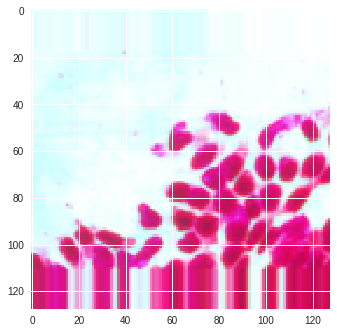

In [29]:
import random
for i in range(4):
  j=random.randint(0,97)
  if labels1[j]==0:
     a_class="benign"
  else:
     a_class="malignant"
  plt.imshow(data1[j])
  print("-----actual class-----")
  print(a_class)
  print("-----predicted label----")
  print(y_classes1[j])


Outputting random images and their tumor types comparing with the predicted.

In [22]:
fpr, tpr, thresholds = metrics.roc_curve(labels1, y_classes, pos_label=2)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


Drawing the ROC curve. fpr-False Positives Rate, tpr-True Positive Rate

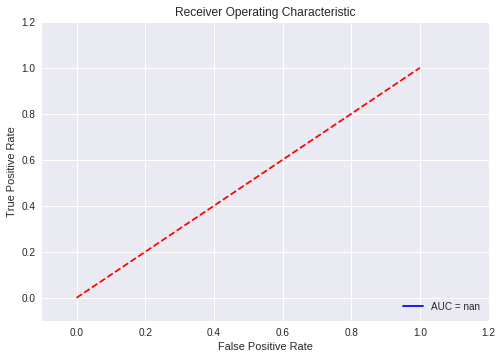

In [23]:
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [30]:
print(classification_report(labels1,y_classes))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       199
           1       0.95      0.93      0.94       199

   micro avg       0.94      0.94      0.94       398
   macro avg       0.94      0.94      0.94       398
weighted avg       0.94      0.94      0.94       398

